In [1]:
import warnings
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

%matplotlib inline

In [2]:
def prep_data_for_clf(df, target, test_size=0.2, random_state=7308):
    X = df.drop(columns=(target), axis=1)
    y = df[target]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)      
 
def prep_housing(df, verbose=True):
    df_c = df.copy()
    thirds = df.shape[0]/3 # locations to split data evenly into thirds
    df_first_split = df['PRICE'].sort_values().iloc[int(thirds)]
    df_second_split = df['PRICE'].sort_values().iloc[int(thirds * 2)]

    df_c['class'] = 'err'
    if verbose:
            print("Group 1 is lte to {}".format(int(df_first_split)))
            print("Group 2 is gt {} and lte to {}".format(int(df_first_split), int(df_second_split)))
            print("Group 3 is gt {}".format(int(df_second_split)))
            print("Adding `class` column via Group designations, this may take a while")

    for i,v in df_c.iterrows():
        if v['PRICE'] <= df_first_split:
            df_c.loc[i, 'class'] = 'Group 1'
        if v['PRICE'] > df_first_split and v['PRICE'] <= df_second_split:
            df_c.loc[i, 'class'] = 'Group 2'
        if v['PRICE'] > df_second_split:
            df_c.loc[i,'class'] = 'Group 3'

    return df_c.drop(columns='PRICE')

In [3]:
def clean_student_data(DATA_PATH, target='gender', save_csv=False):
	"""
	"""

	df_m = pd.read_csv(DATA_PATH)
	df_categorical = [i for i,v in df_m.dtypes.iteritems() if v==object]
	df_categorical.remove(target)
	df_m = create_dummies(df_m, df_categorical)

	if type(save_csv) == str:
		df_m.to_csv(save_csv)

	return df_m

def create_dummies(df, cols):
	df_dummies = pd.concat([pd.get_dummies(df[col]) for col in cols], axis=1)
	df_c = pd.concat([df, df_dummies], axis=1)
	df_c.drop(columns=cols, axis=1, inplace=True)

	return df_c

In [4]:
def measure_execution_time(clf, X_train, y_train, iterations=100):
    training_times = []
    testing_times = []
    
    for _ in range(iterations):
        st = time()
        clf.fit(X_train, y_train)
        et = time()
        training_times.append(et-st)
        
        st = time()
        clf.predict(X_train)
        et = time()
        testing_times.append(et-st)
        
    return training_times, testing_times

In [5]:
def plot_metric(cols, metric, prune, target, xlabel, save=False):
    plt.gcf().set_size_inches(8, 5)
    n_items = len(prune[list(prune.keys())[0]])
    for col in cols:
        plt.plot(range(2, n_items + 2), prune[col])

    plt.legend(['_'.join(i.split('_')[1:]) for i in cols], ncol=1, loc=4)
    plt.xlabel(xlabel)
    plt.ylabel('{} Score (Weighted)'.format(metric.capitalize()))
    if target=='gender':
        plt.title('{} of Train and Test for School'.format(metric.capitalize()))
    if target=='class':
        plt.title('{} of Train and Test for Housing'.format(metric.capitalize()))

    plt.xticks(range(2, n_items + 2))
    plt.grid()
    plt.show()
    
def plot_mlpc_hl(cols, hidden_layers, stats, plt_title):
    plt.gcf().set_size_inches(8, 5)
    for col in cols: 
        plt.plot(hidden_layers, stats[col])
    plt.legend(['Training', 'Testing'], ncol=1, loc=4)
    
    plt.xlabel('Hidden Layers')
    plt.ylabel('Accuracy Score (weighted)')
    plt.xticks(hidden_layers)
    plt.title(plt_title)
    
    plt.grid()
    plt.show()
    
def plot_mlpc_activ(cols, hidden_layers, stats, plt_title):
    plt.gcf().set_size_inches(8, 5)
    for col in cols: 
        plt.plot(hidden_layers, stats[col])
    plt.legend(['identity', 'logistic', 'tanh', 'relu'], ncol=1, loc=4)
    plt.xlabel('Hidden Layers')
    plt.ylabel('Accuracy Score (weighted)')
    plt.xticks(hidden_layers)
    plt.title(plt_title)
    
    plt.grid()
    plt.show()

In [6]:
def plot_learning_curves(dataset, target, clf, plt_title):
    """
    """
    stats = defaultdict(list)
    val_range = range(5,96,5)  # range for test size 
    
    for s in val_range:
        X_train, X_test, y_train, y_test = prep_data_for_clf(df=dataset, target=target,
                                                            test_size=1-s/100, random_state=7308)
        
        clf_ = clf.fit(X_train, y_train)
        train_preds = clf_.predict(X_train)
        test_preds = clf_.predict(X_test)
        
        # cross validation
        scores = cross_val_score(clf, pd.concat([X_train, X_test]), 
                     pd.concat([y_train, y_test]), cv=10)
        stats['cross_val_10'].append(scores.mean())
        
        # accuracy 
        stats['train_acc'].append(accuracy_score(y_true=y_train, y_pred=train_preds))
        stats['test_acc'].append(accuracy_score(y_true=y_test, y_pred=test_preds))
    
    
    plt.gcf().set_size_inches(8, 5)
    plt.plot(val_range, stats['train_acc'])
    plt.plot(val_range, stats['test_acc'])
    plt.plot(val_range, stats['cross_val_10'])
    plt.legend(['Training', 'Testing', '10-Fold Cross Val'], ncol=1, loc=4)
    plt.xlabel('Training size percentage')
    plt.ylabel('Accuracy Score (weighted)')
    plt.title(plt_title)
    plt.xticks(val_range)
    plt.grid()
    plt.show()

In [7]:
def num_hidden(df, classes, alpha):
    """
    From: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097
    """
    return round(df.shape[0]/(alpha * (df.shape[1] + classes)))

[Source](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097)  

$N_h=\frac{N_s}{\alpha∗(N_i+N_o)}$  
Where,  
$N_i$ = number of input neurons.  
$N_o$ = number of output neurons.  
$N_s$ = number of samples in training data set.  
$\alpha$ = an arbitrary scaling factor usually 2-10.

hidden = num_hidden(df_student, 2, alpha=2)
print("Hidden layer size:", df_student.shape[1])
print("Number of hidden layers:", hidden)
clf = MLPClassifier(hidden_layer_sizes=(df_student.shape[1], hidden), max_iter=1000,
                    early_stopping=True, n_iter_no_change=20, random_state=7308)
# clf = DecisionTreeClassifier()
plot_learning_curves(df_student, 'gender', clf, plt_title='Housing Dataset Decision Tree Learning Curves')

In [8]:
def decision_tree_general_analysis(dataset, target, X_train, X_test, y_train, y_test):
    print("######")
    print("Decision Tree Classifier:")
    print('Default Baseline values (no max depth or max leaf nodes)\n')
    clf = DecisionTreeClassifier(random_state=7308)
    plot_learning_curves(dataset, target, clf, plt_title='{} Decision Tree Learning Curves'.format(dataset.index.name))
    print("~~~~~~")
    print("Execution time metrics")
    training_time, testing_time = measure_execution_time(clf, X_train, y_train)
    print("Training time: {:.4f} (+/- {:.4f})".format(np.mean(training_time), np.std(training_time)))
    print("Testing time: {:.4f} (+/- {:.4f})".format(np.mean(testing_time), np.std(testing_time)))
    print("~~~~~~")
    print('\nSplit on Gini Importance:')
    scores = cross_val_score(clf, pd.concat([X_train, X_test]), 
                             pd.concat([y_train, y_test]), cv=10)
    print("10 Fold Cross Validation Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std() * 2))
    
    clf.fit(X_train, y_train)
    preds_train = clf.predict(X_train)
    preds_test = clf.predict(X_test)
    print("Training Accuracy:", accuracy_score(y_true=y_train, y_pred=preds_train))
    print("Training F1:", f1_score(y_true=y_train, y_pred=preds_train, average='weighted'))
    print("Testing Accuracy:", accuracy_score(y_true=y_test, y_pred=preds_test))
    print("Testing F1:", f1_score(y_true=y_test, y_pred=preds_test, average='weighted'))
    print('~~~~~~\n')
    
    print('Split on Entropy Gain:')
    clf = DecisionTreeClassifier(criterion='entropy', random_state=7308)
    
    scores = cross_val_score(clf, pd.concat([X_train, X_test]), 
                             pd.concat([y_train, y_test]), cv=10)
    print("10 Fold Cross Validation Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std() * 2))

    clf.fit(X_train, y_train)
    preds_train = clf.predict(X_train)
    preds_test = clf.predict(X_test)
    print("Training Accuracy:", accuracy_score(y_true=y_train, y_pred=preds_train))
    print("Training F1:", f1_score(y_true=y_train, y_pred=preds_train, average='weighted'))
    print("Testing Accuracy:", accuracy_score(y_true=y_test, y_pred=preds_test))
    print("Testing F1:", f1_score(y_true=y_test, y_pred=preds_test, average='weighted'))
    print("~~~~~~\n")    

    return None

In [9]:
def decision_tree_depth_analysis(dataset, X_train, X_test, y_train, y_test, save=True):
    depth_d = defaultdict(list)  # keep track of test/train accuracies
    for d in range(2, 20):
        clf = DecisionTreeClassifier(max_depth=d, random_state=7308)
        clf.fit(X_train, y_train)
        preds_train = clf.predict(X_train)
        preds_test = clf.predict(X_test)
        
        depth_d['acc_train_gini'].append(accuracy_score(y_true=y_train, y_pred=preds_train))
        depth_d['acc_test_gini'].append(accuracy_score(y_true=y_test, y_pred=preds_test))
        
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=7308)
        clf.fit(X_train, y_train)
        preds_train = clf.predict(X_train)
        preds_test = clf.predict(X_test)

        depth_d['acc_train_entropy'].append(accuracy_score(y_true=y_train, y_pred=preds_train))
        depth_d['acc_test_entropy'].append(accuracy_score(y_true=y_test, y_pred=preds_test))
        
    if save: pd.DataFrame(depth_d, index=range(2,20)).to_csv("./../results/{}_DT_depth_analysis.csv".format(dataset.index.name))
    
    return depth_d

In [10]:
def decision_tree_max_node_analysis(dataset, X_train, X_test, y_train, y_test, save=True):
    max_leaf = defaultdict(list)
    for m in range(2,200, 10):
        clf = DecisionTreeClassifier(max_leaf_nodes=m, random_state=7308)
        clf.fit(X_train, y_train)
        preds_train = clf.predict(X_train)
        preds_test = clf.predict(X_test)

        max_leaf['acc_train_gini'].append(accuracy_score(y_true=y_train, y_pred=preds_train))
        max_leaf['acc_test_gini'].append(accuracy_score(y_true=y_test, y_pred=preds_test))
        
        clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=m, random_state=7308)
        clf.fit(X_train, y_train)
        preds_train = clf.predict(X_train)
        preds_test = clf.predict(X_test)

        max_leaf['acc_train_entropy'].append(accuracy_score(y_true=y_train, y_pred=preds_train))
        max_leaf['acc_test_entropy'].append(accuracy_score(y_true=y_test, y_pred=preds_test))

    if save: pd.DataFrame(max_leaf, index=range(2,200, 10)).to_csv("./../results/{}_DT_max_depth_analysis.csv".format(dataset.index.name))

    return max_leaf

In [31]:
def MLPC_general_analysis(dataset, target, X_train, X_test, y_train, y_test):
    print("######")
    print("Multilayer Perceptron Classifier:")
    print('Default Baseline values\n')
    clf = MLPClassifier(random_state=7308, max_iter=1000)
    plot_learning_curves(dataset, target, clf, plt_title='{} MLPC Learning Curves'.format(dataset.index.name))
    print("~~~~~~")
    print("Execution time metrics")
    training_time, testing_time = measure_execution_time(clf, X_train, y_train, iterations=50)
    print("Training time: {:.4f} (+/- {:.4f})".format(np.mean(training_time), np.std(training_time)))
    print("Testing time: {:.4f} (+/- {:.4f})".format(np.mean(testing_time), np.std(testing_time)))
    print("~~~~~~")
    scores = cross_val_score(clf, pd.concat([X_train, X_test]), 
                             pd.concat([y_train, y_test]), cv=10)
    print("10 Fold Cross Validation Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std() * 2))
    
    clf.fit(X_train, y_train)
    preds_train = clf.predict(X_train)
    preds_test = clf.predict(X_test)
    print("Training Accuracy:", accuracy_score(y_true=y_train, y_pred=preds_train))
    print("Training F1:", f1_score(y_true=y_train, y_pred=preds_train, average='weighted'))
    print("Testing Accuracy:", accuracy_score(y_true=y_test, y_pred=preds_test))
    print("Testing F1:", f1_score(y_true=y_test, y_pred=preds_test, average='weighted'))
    print('~~~~~~\n')
    
    return None
                          
def MLPC_hl_analysis(dataset, target, X_train, X_test, y_train, y_test, save=True):
    print("\nTesting Different Hidden Layer Sizes via Alpha Parameter")
    num_hidden_layers = []
    mlpc_stats = defaultdict(list)
    print("Hidden layer size:", dataset.shape[1])
    n_outputs = dataset[target].nunique()
    for alpha in range(2,11):
        hidden = num_hidden(dataset, n_outputs, alpha)
        num_hidden_layers.append(hidden)
        
        clf = MLPClassifier(hidden_layer_sizes=(dataset.shape[1], hidden), max_iter=1000,
                            early_stopping=True, n_iter_no_change=20, random_state=7308)
        
        clf.fit(X_train, y_train)
        preds_train = clf.predict(X_train)
        preds_test = clf.predict(X_test)
        
        mlpc_stats['train_acc'].append(accuracy_score(y_true=y_train, y_pred=preds_train))
        mlpc_stats['test_acc'].append(accuracy_score(y_true=y_test, y_pred=preds_test))
                          
    results = pd.DataFrame(mlpc_stats, index=num_hidden_layers)
    results['alpha'] = range(2,11)

    plot_mlpc_hl(['train_acc', 'test_acc'], num_hidden_layers, stats=mlpc_hl, 
                 plt_title='MLPC Train and Test Accuracy for {}'.format(dataset.index.name))
    
    if save: results.to_csv("./../results/{}_hidden_layer_analysis.csv".format(dataset.index.name))
    
    return results
                          
def MLPC_activation_analysis(dataset, target, X_train, X_test, y_train, y_test, save=True):
    print("\nTesting Different Activation Functions")
    activations = ['identity', 'logistic', 'tanh', 'relu']
    n_outputs = dataset[target].nunique()
    hidden = num_hidden(dataset, n_outputs, 3)
                          
    accuracy = []
    stdev = []
                          
    for activation in activations:

        clf = MLPClassifier(activation=activation, hidden_layer_sizes=(dataset.shape[1], hidden), max_iter=1000,
                            early_stopping=True, n_iter_no_change=20, random_state=7308)
                          
        scores = cross_val_score(clf, pd.concat([X_train, X_test]), 
                                 pd.concat([y_train, y_test]), cv=10)
        
        accuracy.append(scores.mean())
        stdev.append(scores.std() * 2)
    
    results = pd.DataFrame(index=activations, data=np.array([accuracy, stdev]).T, columns=['acc', 'std'])
    if save: results.to_csv("./../results/{}_MLPC_activation_analysis.csv".format(dataset.index.name))
                          
    return results

######
Decision Tree Classifier:
Default Baseline values (no max depth or max leaf nodes)



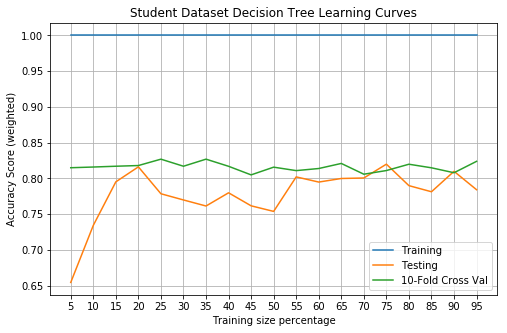

~~~~~~
Execution time metrics
Training time: 0.0030 (+/- 0.0004)
Testing time: 0.0008 (+/- 0.0002)
~~~~~~

Split on Gini Importance:
10 Fold Cross Validation Accuracy: 0.8199 (+/- 0.0684)
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.79
Testing F1: 0.79
~~~~~~

Split on Entropy Gain:
10 Fold Cross Validation Accuracy: 0.8081 (+/- 0.0838)
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.825
Testing F1: 0.8251972744808236
~~~~~~



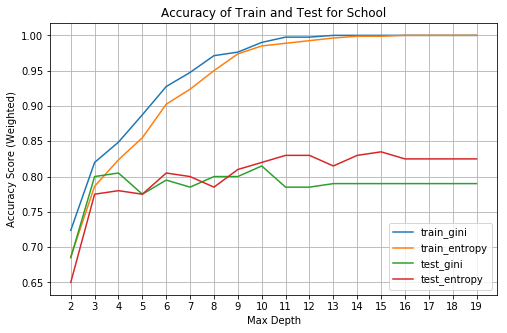

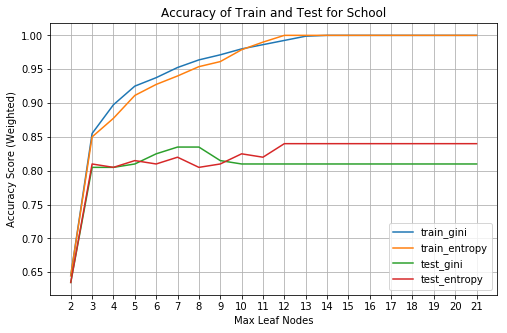

Completed Decision Tree Analysis
--------------------------------

######
Multilayer Perceptron Classifier:
Default Baseline values



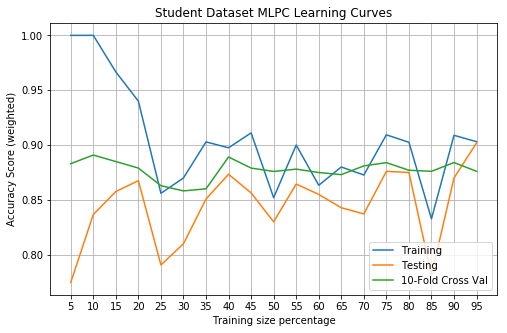

~~~~~~
Execution time metrics
Training time: 0.4865 (+/- 0.0126)
Testing time: 0.0013 (+/- 0.0002)
~~~~~~
10 Fold Cross Validation Accuracy: 0.8770 (+/- 0.0695)
Training Accuracy: 0.9025
Training F1: 0.9025109690242256
Testing Accuracy: 0.875
Testing F1: 0.87515331280819
~~~~~~


Testing Different Hidden Layer Sizes via Alpha Parameter
Hidden layer size: 20


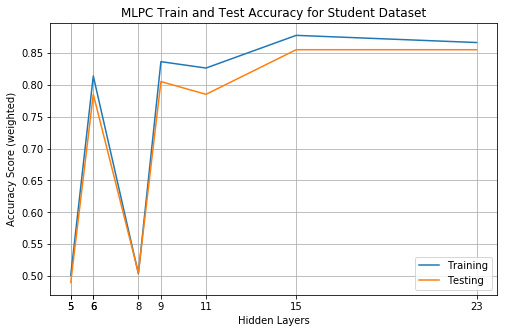


Testing Different Activation Functions
~~~~~~



In [32]:
df_student = pd.read_csv("./../cleaned_student_data.csv")
df_student.index.name = 'Student Dataset'
# df_housing = pd.read_csv("./../cleaned_housing_data_preped_class.csv")
# df_housing.index.name = 'Housing Dataset'

df_student_target = 'gender'
# df_housing_target = 'class'
save = False
for dataset, target in zip([df_student], [df_student_target]):
    X_train, X_test, y_train, y_test = prep_data_for_clf(df=dataset, target=target,
                                                        random_state=7308)
    
    # decision tree analysis
    decision_tree_general_analysis(dataset, target, X_train, X_test, y_train, y_test)
    depth_d = decision_tree_depth_analysis(dataset, X_train, X_test, y_train, y_test, save)
    max_leaf = decision_tree_max_node_analysis(dataset, X_train, X_test, y_train, y_test, save)
    
    accs = ['acc_train_gini', 'acc_train_entropy', 'acc_test_gini', 'acc_test_entropy']
    plot_metric(cols=accs, metric='accuracy', prune=depth_d, target=target, xlabel='Max Depth')
    plot_metric(cols=accs, metric='accuracy', prune=max_leaf, target=target, xlabel='Max Leaf Nodes')
    
    print("Completed Decision Tree Analysis")
    print("--------------------------------\n")
    
    
    # MLPC 
    MLPC_general_analysis(dataset, target, X_train, X_test, y_train, y_test)
    mlpc_hl = MLPC_hl_analysis(dataset, target, X_train, X_test, y_train, y_test, save)
    mlpc_activ = MLPC_activation_analysis(dataset, target, X_train, X_test, y_train, y_test, save)

#     plot_mlpc_hl(['train_acc', 'test_acc'], num_hidden_layers, stats=mlpc_hl, 
#                  plt_title='MLPC Train and Test Accuracy for {}'.format(dataset.index.name))
    
    print("~~~~~~\n")